In [1]:
import pandas as pd
import seaborn as sns
import acquire
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_regression

## Acquire/Preparing (Wrangling)

What does the data look like?

In [2]:
df = acquire.zillow_data()
df

,parcelid,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,basementsqft,...,id,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,17173851,NaN,NaN,261.0,NaN,None,NaN,NaN,787,NaN,...,389.0,0.088469,2017-01-03,None,None,None,None,Single Family Residential,None,None
1,10821119,NaN,NaN,261.0,2.0,None,NaN,NaN,1702,NaN,...,402.0,0.025629,2017-01-03,None,None,None,Central,Single Family Residential,None,None
2,11007640,NaN,NaN,261.0,2.0,None,NaN,1.0,2412,NaN,...,2699.0,0.020360,2017-01-12,Central,None,None,Central,Single Family Residential,None,None
3,11457850,NaN,NaN,261.0,7.0,None,NaN,NaN,3770,NaN,...,2229.0,0.054233,2017-01-11,None,None,None,Floor/Wall,Single Family Residential,None,None
4,12591550,NaN,NaN,261.0,2.0,None,NaN,NaN,8197,NaN,...,3038.0,-0.016170,2017-01-13,None,None,None,Central,Single Family Residential,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52437,12885754,NaN,NaN,261.0,7.0,None,NaN,NaN,2976765,NaN,...,42657.0,0.515289,2017-06-01,None,None,None,Floor/Wall,Single Family Residential,None,None
52438,13869000,NaN,NaN,261.0,NaN,None,NaN,NaN,2977815,NaN,...,32297.0,0.009512,2017-05-02,None,None,None,None,Single Family Residential,None,None
52439,13890509,NaN,NaN,261.0,NaN,None,NaN,NaN,2977914,NaN,...,28537.0,-0.031048,2017-04-21,None,None,None,None,Single Family Residential,None,None
52440,17246810,NaN,NaN,261.0,NaN,None,NaN,NaN,2980979,NaN,...,8396.0,-0.031665,2017-02-07,None,None,None,None,Single Family Residential,None,None


## Prepare

- let's get an idea of what the logerror is and looks like
- the max and min are pretty close apart 
- i want just the outliers
- i do not know what the negative or positive logerror mean wether they over or underestimated the price

In [3]:
df.logerror.describe()

count    52441.000000
mean         0.018298
std          0.177501
min         -4.655420
25%         -0.024639
50%          0.007011
75%          0.040692
max          5.262999
Name: logerror, dtype: float64

Where are the nulls?

In [4]:
df.isnull().sum()

parcelid                      0
typeconstructiontypeid    52366
storytypeid               52395
propertylandusetypeid         0
heatingorsystemtypeid     18507
                          ...  
buildingclassdesc         52442
heatingorsystemdesc       18507
propertylandusedesc           0
storydesc                 52395
typeconstructiondesc      52366
Length: 69, dtype: int64

<b>We have many columns with mostly null values</b>

In [5]:
df.shape

(52442, 69)

> Your audience for this project is a data science team. The presentation will consist of a notebook demo of the discoveries you made and work you have done related to uncovering what the drivers of the error in the zestimate is.
<br>
<a href="https://ds.codeup.com/clustering/project/">Project Source</a>

><i>𝑙𝑜𝑔𝑒𝑟𝑟𝑜𝑟=𝑙𝑜𝑔(𝑍𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒)−𝑙𝑜𝑔(𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒)</i>
<br>
<a href="https://www.kaggle.com/competitions/zillow-prize-1/data">from zillow website</a>

<div>This series of observations on trying to understand logerror has led me back to the acquireing stage to narrow in what I am looking for. From here in order to head towards my MVP model I shall no longer mess with the data coming in. Rather here in I will explore and find what I will. Exploration can take a while so it is best I set up goals.</div>
> positive log error means that the price was overestimated, negative log error means that the price was underestimated

<div>Since I am going to re-acquire my data I can now plan out where and how I am going to handle the outliers, we handle outliers because it messes with our machine learnign accuracy in a negative way.</div>

<div>So this then begs the question what is a threshold I can set to where we need to start worrying about. It would take a good bit of time to have a great reason mathematically. For now maybe I can look at where the error lies in terms of the described info of logerror. Just pick a number (|.03|), fine I will change it. I just realised that I will need both a lower and upper bound limits to control the amount of data coming through. In normal speak that is, handle outliers. The upper bound threshold will be 3 while the lower bound threshold is .03 </div>

Sweet! even though I have cut my original data set in half I should be able  to have enough to workthrough. From here in I can split the data before further investigating

<b>Dropping columns that have columns with <90% empty values</b>

In [6]:
acquire.handle_missing_values(df, prop_required_column=.9, prop_required_row=0)

,parcelid,propertylandusetypeid,id,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,id,logerror,transactiondate,propertylandusedesc
0,17173851,261.0,787,2.0,4.0,2.0,1848.0,1848.0,6111.0,2.0,...,47193.0,64712.0,2016.0,17519.0,781.00,6.111004e+13,389.0,0.088469,2017-01-03,Single Family Residential
1,10821119,261.0,1702,2.0,2.0,2.0,1430.0,1430.0,6037.0,2.0,...,107511.0,381638.0,2016.0,274127.0,4692.27,6.037131e+13,402.0,0.025629,2017-01-03,Single Family Residential
2,11007640,261.0,2412,2.0,3.0,2.0,1572.0,1572.0,6037.0,2.0,...,144802.0,305307.0,2016.0,160505.0,3887.80,6.037106e+13,2699.0,0.020360,2017-01-12,Single Family Residential
3,11457850,261.0,3770,2.0,3.0,2.0,1412.0,1412.0,6037.0,2.0,...,38700.0,93146.0,2016.0,54446.0,1246.18,6.037276e+13,2229.0,0.054233,2017-01-11,Single Family Residential
4,12591550,261.0,8197,2.0,3.0,2.0,1352.0,1352.0,6037.0,2.0,...,96651.0,482242.0,2016.0,385591.0,6098.62,6.037544e+13,3038.0,-0.016170,2017-01-13,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52437,12885754,261.0,2976765,1.0,3.0,1.0,1021.0,1021.0,6037.0,1.0,...,93397.0,200214.0,2016.0,106817.0,2629.33,6.037403e+13,42657.0,0.515289,2017-06-01,Single Family Residential
52438,13869000,261.0,2977815,2.0,4.0,2.0,1554.0,1554.0,6059.0,2.0,...,135043.0,215695.0,2016.0,80652.0,2607.04,6.059002e+13,32297.0,0.009512,2017-05-02,Single Family Residential
52439,13890509,261.0,2977914,4.0,3.0,4.0,2880.0,2880.0,6059.0,4.0,...,271027.0,1389962.0,2016.0,1118935.0,14935.72,6.059063e+13,28537.0,-0.031048,2017-04-21,Single Family Residential
52440,17246810,261.0,2980979,2.5,3.0,2.5,1376.0,1376.0,6111.0,2.0,...,201839.0,403678.0,2016.0,201839.0,4880.90,6.111008e+13,8396.0,-0.031665,2017-02-07,Single Family Residential


In [7]:
df.columns

Index(['parcelid', 'typeconstructiontypeid', 'storytypeid',
       'propertylandusetypeid', 'heatingorsystemtypeid', 'buildingclasstypeid',
       'architecturalstyletypeid', 'airconditioningtypeid', 'id',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'latitude',
       'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr',
       'unitcnt', 'yardbuildingsqft17',

This fills in may of the rows that are empty

In [8]:
df = df.fillna(0)

I have dropped over 60 columns that had 90% of their entries empty. Now what?
We can start graphing stuff, possibly build out graphs to start seeing some of those relationships if there are any.

<b>Splitting the data</b>

In [9]:
train, validate, test = acquire.traintestsplit(df)

typeconstructiontypeid - the material used in the building process
storytypeid - the amount of floors the building has
propertylandusetypeid - 

In [10]:
#dropping off columns that are 90% empty
df = acquire.handle_missing_values(df,prop_required_column=.9,prop_required_row=0)

Now that the columns are dropped I am also going to neeed to trim excess material

In [11]:
df = acquire.drop_cat_columns(df)
df.head()

,typeconstructiontypeid,storytypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,...,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,storydesc,typeconstructiondesc
0,0.0,0.0,0.0,0,0.0,0.0,0.0,2.0,4.0,0.0,...,0,0.0,6.111004e+13,0.088469,0,0,0,0,0,0
1,0.0,0.0,2.0,0,0.0,0.0,0.0,2.0,2.0,6.0,...,0,0.0,6.037131e+13,0.025629,0,0,0,Central,0,0
2,0.0,0.0,2.0,0,0.0,1.0,0.0,2.0,3.0,8.0,...,0,0.0,6.037106e+13,0.020360,Central,0,0,Central,0,0
3,0.0,0.0,7.0,0,0.0,0.0,0.0,2.0,3.0,6.0,...,0,0.0,6.037276e+13,0.054233,0,0,0,Floor/Wall,0,0
4,0.0,0.0,2.0,0,0.0,0.0,0.0,2.0,3.0,6.0,...,0,0.0,6.037544e+13,-0.016170,0,0,0,Central,0,0


In [12]:
df = acquire.takeout_outliers1(df)

In [13]:
df.head()

,typeconstructiontypeid,storytypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,...,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,storydesc,typeconstructiondesc
0,0.0,0.0,0.0,0,0.0,0.0,0.0,2.0,4.0,0.0,...,0,0.0,6.111004e+13,0.088469,0,0,0,0,0,0
3,0.0,0.0,7.0,0,0.0,0.0,0.0,2.0,3.0,6.0,...,0,0.0,6.037276e+13,0.054233,0,0,0,Floor/Wall,0,0
5,0.0,0.0,2.0,0,0.0,1.0,0.0,1.0,3.0,4.0,...,0,0.0,6.037553e+13,0.442837,Central,0,0,Central,0,0
6,0.0,0.0,0.0,0,0.0,0.0,0.0,1.5,2.0,0.0,...,0,0.0,6.059042e+13,0.087099,0,0,0,0,0,0
8,0.0,0.0,0.0,0,0.0,0.0,0.0,3.0,4.0,0.0,...,0,0.0,6.059063e+13,0.032578,0,0,0,0,0,0


## Explore

In [14]:
train, validate, test = acquire.traintestsplit(df)

the data is split and looking healthy

In [15]:
train_scaled, validate_scaled, test_scaled = acquire.splitmoreways(train, validate, test)

In [16]:
train_scaled.head()

,typeconstructiontypeid,storytypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,...,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,storydesc,typeconstructiondesc
40731,0.0,0.0,7.0,0,0.0,0.0,0.0,0.090909,0.3,4.0,...,0,0.0,0.125001,-0.048415,0,0,0,Floor/Wall,0,0
1059,0.0,0.0,7.0,0,0.0,0.0,0.0,0.090909,0.3,4.0,...,0,0.0,0.124993,0.171315,0,0,0,Floor/Wall,0,0
48642,0.0,0.0,0.0,0,0.0,0.0,0.0,0.181818,0.4,0.0,...,0,0.0,0.125437,0.066977,0,0,0,0,0,0
42603,0.0,0.0,2.0,0,0.0,1.0,0.0,0.181818,0.3,6.0,...,0,0.0,0.125001,0.037205,Central,0,0,Central,0,0
17181,0.0,0.0,7.0,0,0.0,0.0,0.0,0.181818,0.3,6.0,...,0,0.0,0.124988,0.037416,0,0,0,Floor/Wall,0,0


I have dropped off features that are categorical values. These mean close tp nothing to my ML models. Since ML models do best on spectrums of data rather then definite types

Well it seems that this error auto-magically fixed itself after a kernel

What does the distribution of logerror look like?

<AxesSubplot:ylabel='logerror'>

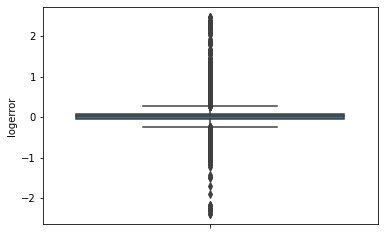

In [18]:
sns.boxplot(y=train.logerror, data=train)
#even though I have scaled my data I can go back and re-edit my outliers

In [19]:
train.logerror.describe()

count    15598.000000
mean         0.032996
std          0.231020
min         -2.406257
25%         -0.053620
50%          0.037586
75%          0.079135
max          2.479045
Name: logerror, dtype: float64

<b>Takeaways: the vast majority of the errors are on the lower end around 0.03</b>

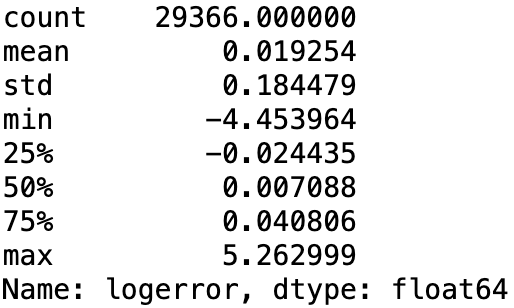

## Explore

In [20]:
alpha = 0.05

### What is the relationship between bathroomcnt and logerror?

<AxesSubplot:xlabel='bathroomcnt', ylabel='logerror'>

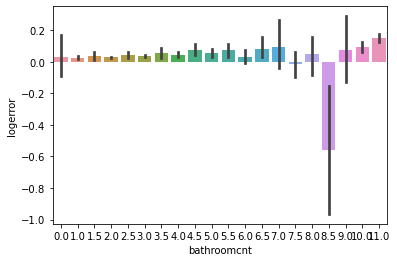

In [21]:
sns.barplot(x=train.bathroomcnt, y=train.logerror)
#what in good god happened at the 8.5 bath

### What is the relationship between error rate and bathroom count?

Null-Hypothesis: There is no relationship between bathrooms and log_error
<br>
Alternative-Hypothesis: There is a relationship between bathrooms and log_error

<AxesSubplot:xlabel='bathroomcnt', ylabel='logerror'>

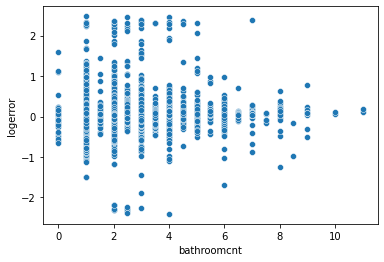

In [22]:
# only need like 3 or 4 exploring techniques to be able to deliver an MVP
sns.scatterplot(x=train.bathroomcnt, y=train.logerror)
#this here tells us that there is a little more inaccuracy around 1-5 bathrooms
#to make proper use of statistics write out with numbers where the differences appear
#model is overweight one one side

In [23]:
test_results = stats.pearsonr(train.bathroomcnt , train.logerror )
test_results
print(test_results)
r, p = test_results
print(f'P is {p:.10f}')
if p < alpha:
    print('Therefore we reject the null hypothesis')

(0.03260304334438578, 4.648842567219295e-05)
P is 0.0000464884
Therefore we reject the null hypothesis


- takeaway: there is a larger range of error between 1 and 5 bathrooms
- the statistical test is telling us that although the relationship exists it is not a very strong signal

### What does the log error look like/where are the concentrations?

<AxesSubplot:xlabel='logerror', ylabel='Count'>

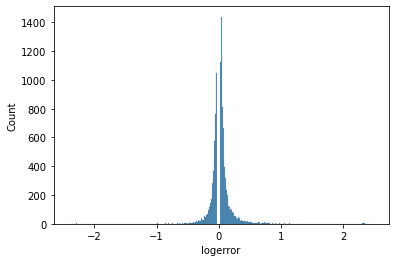

In [24]:
#histograms usually work off one variable
sns.histplot(x=train.logerror)

Takeaways: 
- there are more positive cases of error < 0.03 then there are negative
- which looks much different when zoomed out at a macro scale

### What does the distribution of bedrooms look like

In [25]:
train.bedroomcnt.value_counts()

3.0     6679
4.0     4298
2.0     2796
5.0     1244
6.0      246
1.0      225
0.0       51
7.0       40
8.0       14
9.0        4
10.0       1
Name: bedroomcnt, dtype: int64

Most of the entries have 2, 3, and 4 bedrooms

<hr>

I now need stats test for continuous on continous data not sure what calculations to use so will go there shortly

This would mean numerical stats tests

These include:
- ANOVA
- t-test
- Mann Whitney U test
- Pearson R
- paired T-test

### Where do the errors lie in relation to taxvaluedollarcnt

<AxesSubplot:xlabel='taxvaluedollarcnt', ylabel='logerror'>

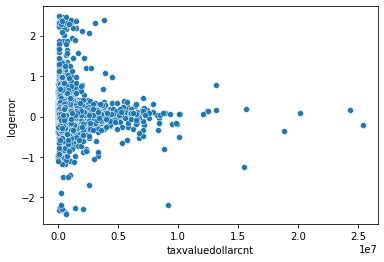

In [26]:
sns.scatterplot(y=train.logerror,x=train.taxvaluedollarcnt)
#hey wait a minute it seems to be all in a small area here

Takeaways:
- that the majority of the errors seem to be around the lower price point

<b>Preparing takeaways:
- over half of the columns dropped
- some of the nulls were filled in with zeros
- the amount of rows has been halved from the floor and cieling I had set
</b>

## Modeling

I want to get an idea of what the logerror were to look like if it was clustered and overlayed onto a map

In [27]:
#label what we want clustered
X = train[["logerror"]]
#get the thing
kmeans = KMeans(n_clusters=5)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
train['cluster'] = kmeans.predict(X)

[4 0 0 ... 1 4 0]


### Where is the best amount of clusters

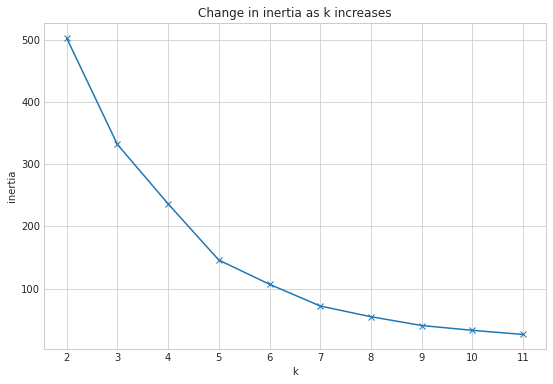

In [28]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

Takeaway:
- the magic number of clusters is anywhere between 5 and 7

In [29]:
kmeans.cluster_centers_
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,logerror
0,0.084440
1,0.497906
2,1.930093
3,-0.933584
4,-0.091332


In [30]:
train.logerror.value_counts()

-0.033416    2
 0.031597    2
 0.036168    2
 0.051113    2
-0.044769    2
            ..
 0.190799    1
 0.066070    1
 0.076103    1
 0.190151    1
 0.041462    1
Name: logerror, Length: 15592, dtype: int64

### What do the clusters look like when there are 5 of them

Text(0.5, 1.0, 'Visualizing Cluster Centers')

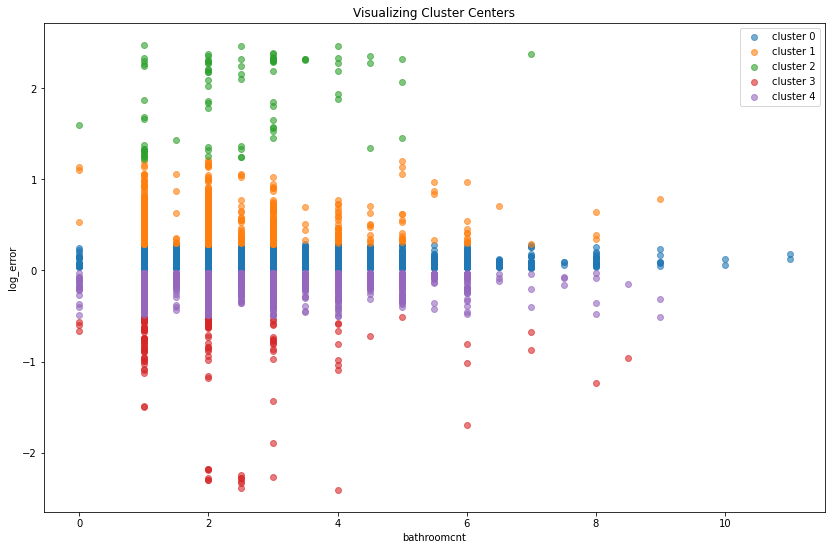

In [31]:
plt.figure(figsize=(14, 9))

for cluster, subset in train.groupby('cluster'):
    plt.scatter( subset.bathroomcnt , subset.logerror, label='cluster ' + str(cluster), alpha=.6)
plt.legend()
plt.xlabel('bathroomcnt')
plt.ylabel('log_error')
plt.title('Visualizing Cluster Centers')

### Where are the groups the clusters live in

<AxesSubplot:xlabel='cluster', ylabel='logerror'>

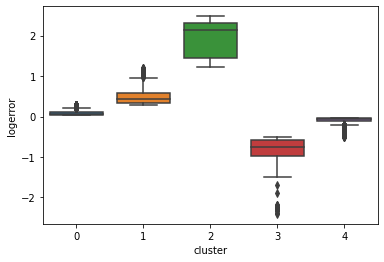

In [32]:
#don't let this in the x train of my models
sns.boxplot(x="cluster", y="logerror", data=train)
#2 clusters are pretty accurate 

#1 cluster over shoots a little bit
#2 clusters have my clues
# one positive and one negative

Takeaway:
- 2 clusters are pretty accurate 
- 1 cluster over shoots a little bit
- 2 clusters have my clues
  - one positive and one negative

Numerical amount of groups

In [33]:
train.cluster.value_counts()

0    8302
4    6360
1     726
3     130
2      80
Name: cluster, dtype: int64

Most of the misses are percise

most of the predictions while off were fairly accurate


the outliers are way smaller then expected


may have to zoom in on or find another interpretation

### What does the distribution look like with 6 clustering groups on logerror

In [34]:
#label what we want clustered
X = train[["logerror"]]
#get the thing
kmeans = KMeans(n_clusters=6)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
train['cluster'] = kmeans.predict(X)

[0 2 2 ... 1 0 2]


Text(0.5, 1.0, 'Visualizing Cluster Centers')

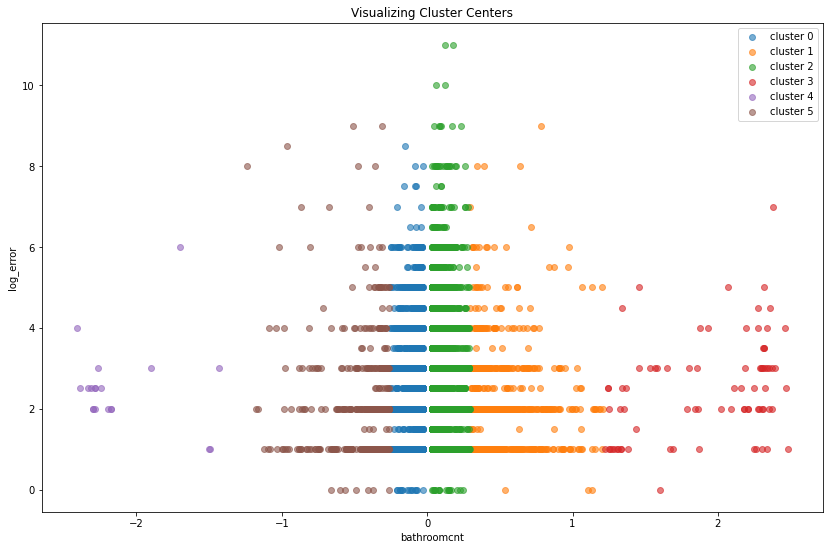

In [35]:
# X = train[["logerror"]]
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
plt.figure(figsize=(14, 9))

for cluster, subset in train.groupby('cluster'):
    plt.scatter(subset.logerror, subset.bathroomcnt,label='cluster ' + str(cluster), alpha=.6)

# centroids.plot.scatter(y='log_error', x='bathroomcnt', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('bathroomcnt')
plt.ylabel('log_error')
plt.title('Visualizing Cluster Centers')

The results are very similar to the one with 5 cluster points but this one shows us that there is a subsection at 4 worth investigating

### Where are the groups the clusters live in

<AxesSubplot:xlabel='cluster', ylabel='logerror'>

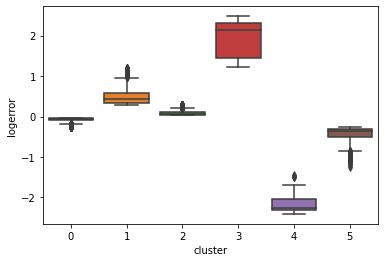

In [36]:
sns.boxplot(x="cluster", y="logerror", data=train)

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

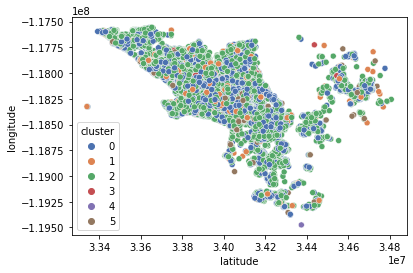

In [37]:
sns.scatterplot(x=train.latitude,y=train.longitude, hue=train.cluster, palette="deep")

In [38]:
train.cluster.value_counts()

2    8305
0    6037
1     723
5     434
3      80
4      19
Name: cluster, dtype: int64

Takeaway:
- The smaller outliers are getting squeezed

Summary so far:

Most of the errors live within a small margin of error

<hr>

### What if we used 4 cluster groups

In [39]:
#label what we want clustered
X = train[["logerror"]]
#get the thing
kmeans = KMeans(n_clusters=4)
#fit the thing
kmeans.fit(X)
#run the thing
print(kmeans.predict(X))
#make new column named cluster that holds their clustere value group 0-4
train['cluster'] = kmeans.predict(X)

[2 0 0 ... 3 2 0]


Text(0.5, 1.0, 'Visualizing Cluster Centers')

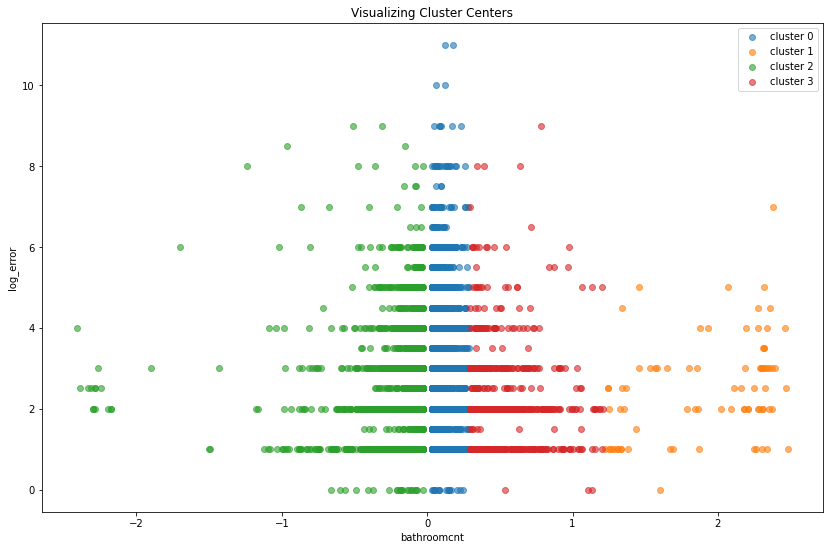

In [40]:
# X = train[["logerror"]]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
plt.figure(figsize=(14, 9))

for cluster, subset in train.groupby('cluster'):
    plt.scatter(subset.logerror, subset.bathroomcnt,label='cluster ' + str(cluster), alpha=.6)

# centroids.plot.scatter(y='log_error', x='bathroomcnt', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('bathroomcnt')
plt.ylabel('log_error')
plt.title('Visualizing Cluster Centers')

<AxesSubplot:xlabel='cluster', ylabel='logerror'>

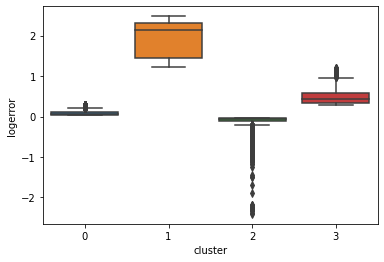

In [41]:
sns.boxplot(x="cluster", y="logerror", data=train)

In [42]:
train.cluster.value_counts()

0    8305
2    6490
3     723
1      80
Name: cluster, dtype: int64

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

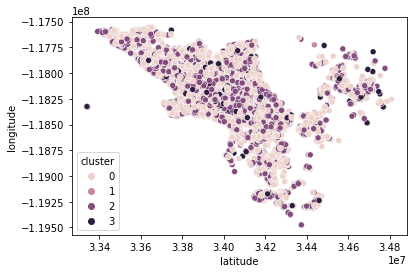

In [43]:
sns.scatterplot(x=train.latitude,y=train.longitude, hue=train.cluster)

<hr>

I am so lost right now
 I kinda want to go back and do a select k-best to determine what is valued and what isn't

In [44]:
from sklearn.feature_selection import SelectKBest, f_regression

In [45]:
train.columns.shape

(58,)

More importantly we have a hug revaltion!:
- I have found the order of impact my drivers are to logerror
- Oddly enough they also look like taxvaluedollarcnt drivers which is...odd
    - bathroomcnt
    - bedroomcnt
    - calculatedbathnbr
    - calculatedfinishedsquarefeet
    - finishedsquarefeet12
    - fullbathcnt
    - latitude
    - longitude
    - lotsizesquarefeet
    - rawcensustractandblock
    - roomcnt
    - yearbuilt
    - landtaxvaluedollarcn
    - landtaxvaluedollarcnt
    - taxamount
    - censustractandblock

In [46]:
train.cluster

40731    2
1059     0
48642    0
42603    0
17181    0
        ..
39497    0
22243    2
5965     3
51844    2
21684    0
Name: cluster, Length: 15598, dtype: int32

This cell is cleaned of all bugs and now runs smooth as a whistle

What now?

Am taking as break is what now 

My next step would be to re-explore my top 5 driving factors

### Explore part 2
> electric boogaloo

This is where I make more seaborn charts to plot out what exactly is happening woth my data

What does the general shape of my leading drivers look like?

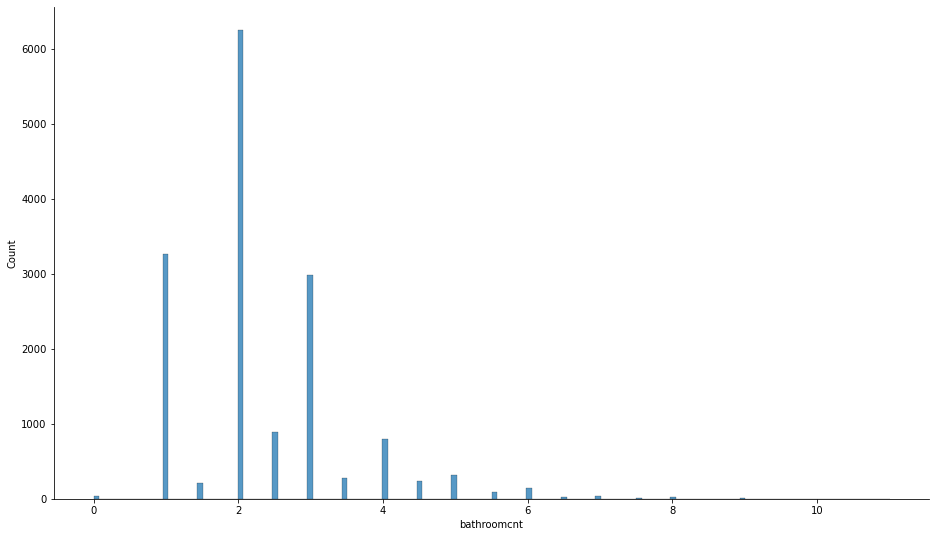

In [47]:
sns.displot(train.bathroomcnt)
plt.gcf().set_size_inches(15, 8)

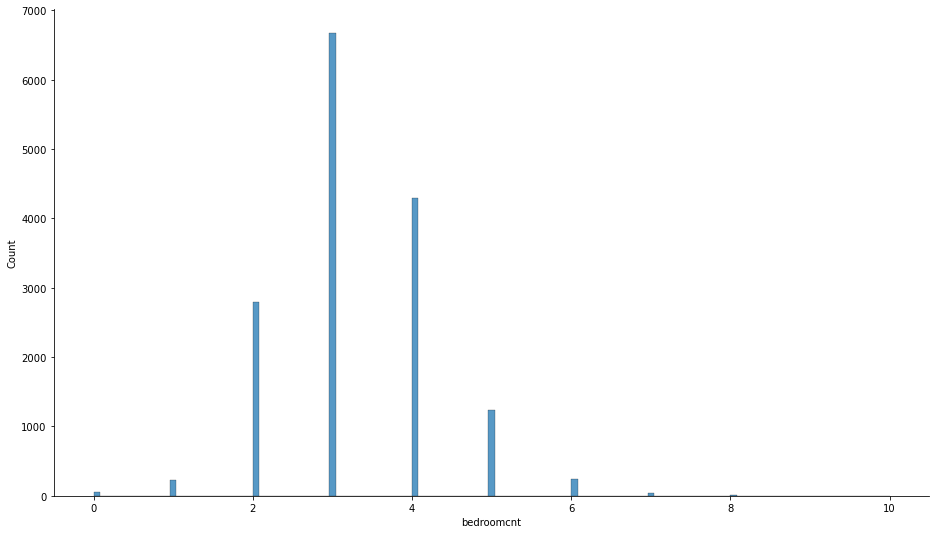

In [48]:
sns.displot(train.bedroomcnt)
plt.gcf().set_size_inches(15, 8)

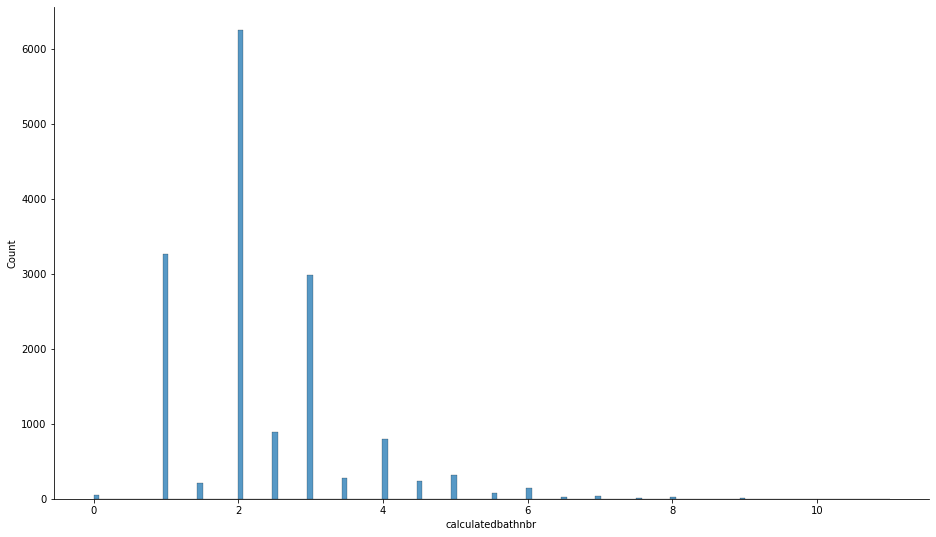

In [49]:
sns.displot(train.calculatedbathnbr)
plt.gcf().set_size_inches(15, 8)

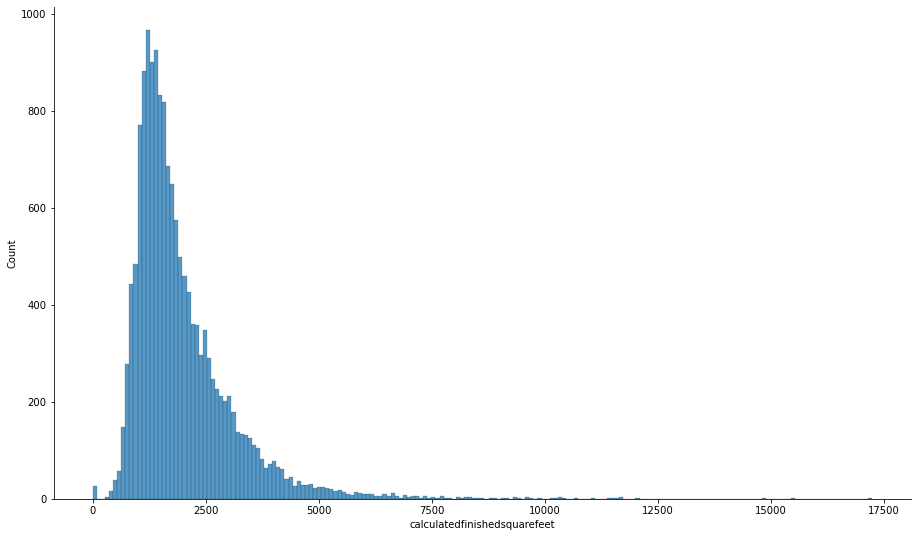

In [50]:
sns.displot(train.calculatedfinishedsquarefeet)
plt.gcf().set_size_inches(15, 8)

This looks identical to the feature above

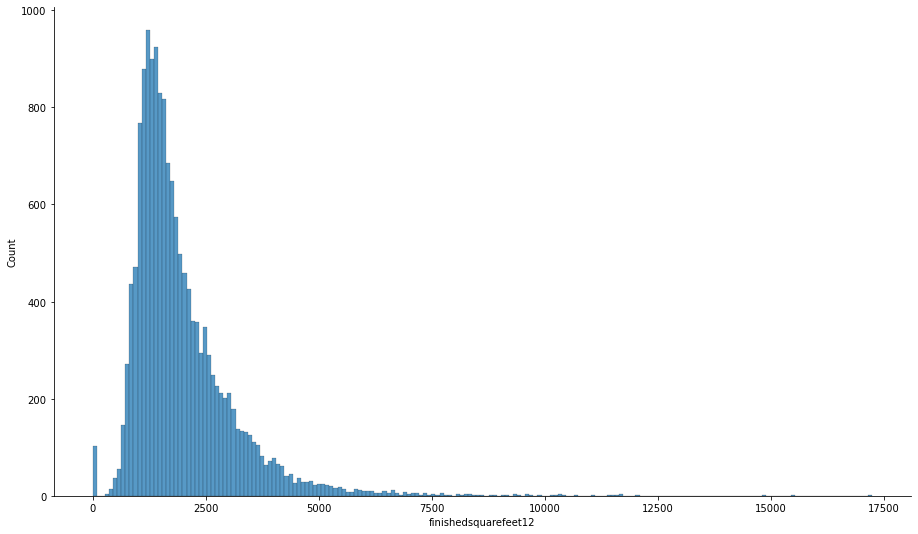

In [51]:
sns.displot(train.finishedsquarefeet12)
plt.gcf().set_size_inches(15, 8)

What do  my leading drivers look compared to my target variable?

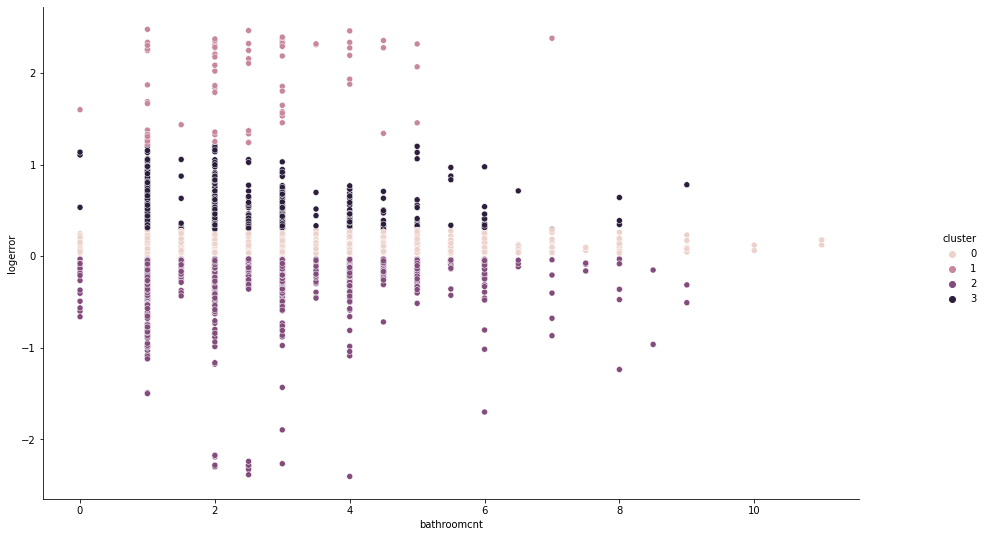

In [52]:
sns.relplot(x=train.bathroomcnt, y=train.logerror, hue=train.cluster)
plt.gcf().set_size_inches(15, 8)

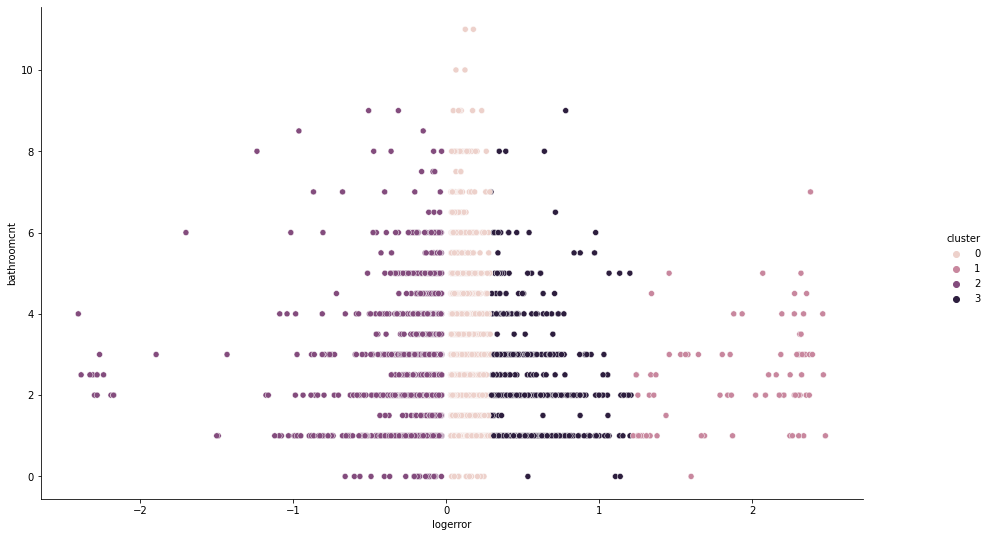

In [53]:
sns.relplot(y=train.bathroomcnt, x=train.logerror, hue=train.cluster)
plt.gcf().set_size_inches(15, 8)

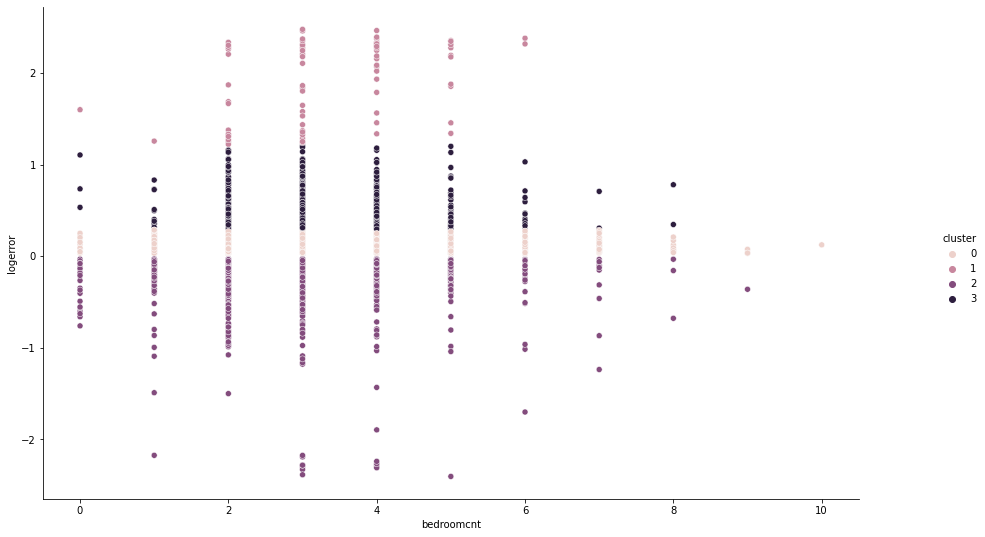

In [54]:
sns.relplot(x=train.bedroomcnt, y=train.logerror, hue=train.cluster)
plt.gcf().set_size_inches(15, 8)

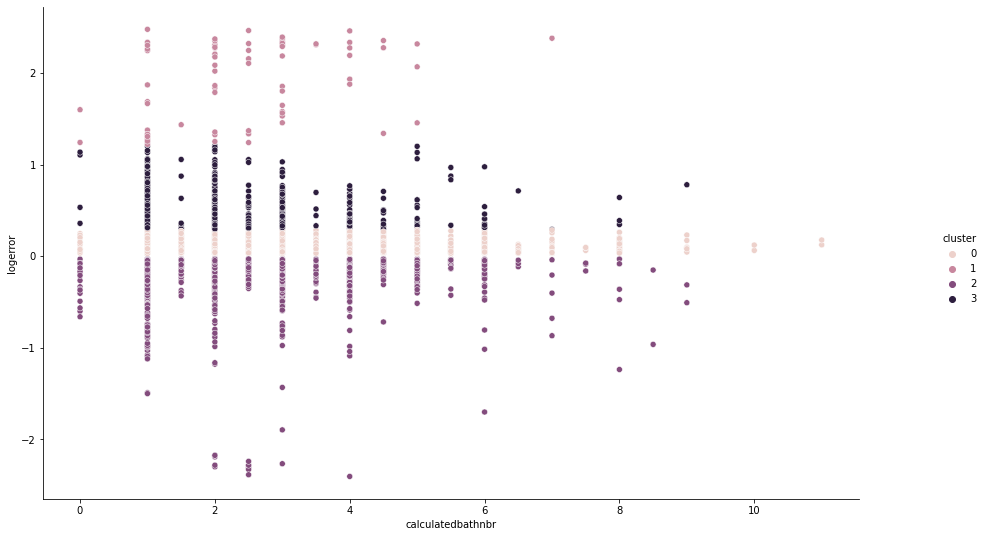

In [55]:
sns.relplot(x=train.calculatedbathnbr, y=train.logerror, hue=train.cluster)
plt.gcf().set_size_inches(15, 8)

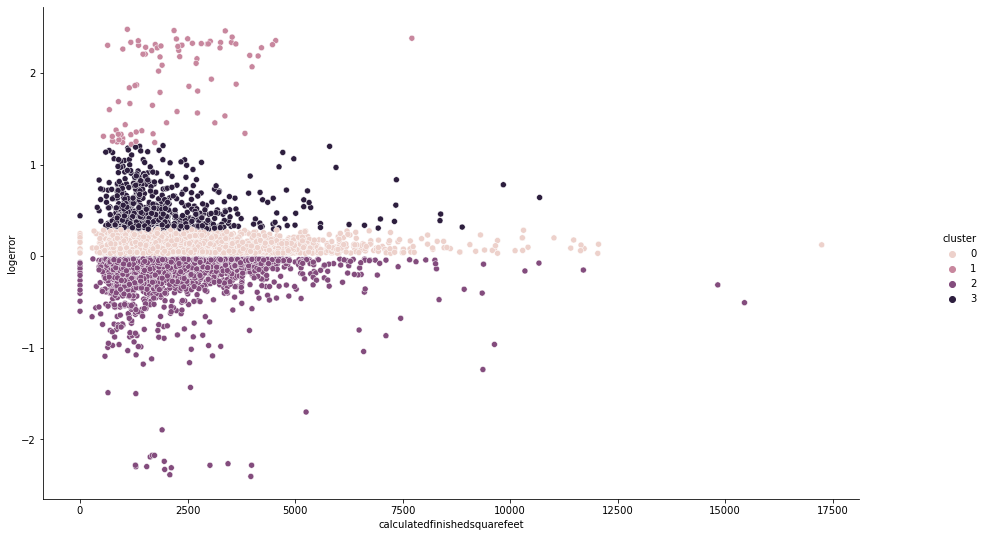

In [56]:
sns.relplot(x=train.calculatedfinishedsquarefeet, y=train.logerror, hue=train.cluster)
plt.gcf().set_size_inches(15, 8)

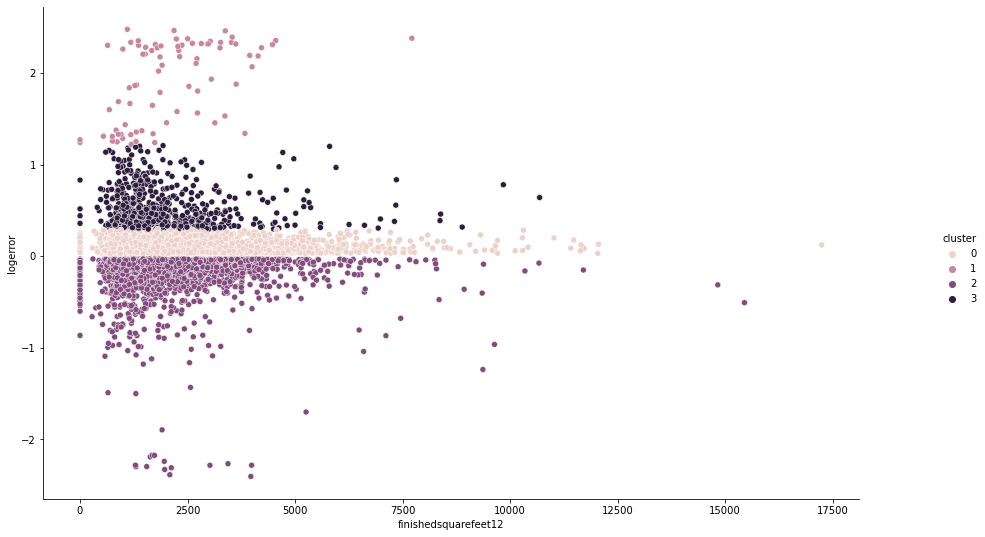

In [57]:
sns.relplot(x=train.finishedsquarefeet12, y=train.logerror, hue=train.cluster)
plt.gcf().set_size_inches(15, 8)

### What does the physical dispurtion of the cluster look like

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

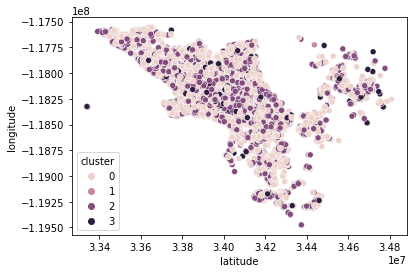

In [58]:
sns.scatterplot(x=train.latitude,y=train.longitude, hue=train.cluster)

In [59]:
train.cluster.value_counts()

0    8305
2    6490
3     723
1      80
Name: cluster, dtype: int64

<AxesSubplot:xlabel='cluster', ylabel='logerror'>

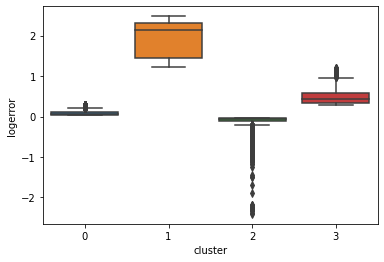

In [60]:
sns.boxplot(x="cluster", y="logerror", data=train)

Takeaways:
> inconclusive

I can name the in useful ways like:
- a little under
- a little over
- way under 
- way over

- Modeling: At least 4 different models are created and their performance is compared. One model is the distinct combination of algorithm, hyperparameters, and features.

- Clustering could be useful in several ways on this project:
    - Do clusters produce an interesting insight, takeaway, or visualization that can be shared and communicated?
    - With a small number of clusters, clusters could be one-hot encoded and used as a feature for modeling.
    - Different models can be created for different clusters (while conceptually simple, this involves a much more complicated python implementation, so you should probably treat this idea as a bonus)
- Sometimes your conclusion is that there is no effect or no significant difference. This is a valid conclusion in and of itself.
- You might wish to start working in a notebook or to split your work up into multiple notebooks. This is totally fine and makes sense so long as eventually you clean up and transfer the work to a final notebook and/or python scripts.



#### self checkpoint, need to make and use other clusters. 
> just logerror will not work
> plan on combinations of features
> - starting off with clusters of top 2 feats.

<i>The rest of the modeling and clustering are in the "fixing" jupyter notebook</i>